# SMS Spam Detection

The file we are going to use contains a collection of more than 5 thousand SMS phone messages. Using labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

Here I  am going to develop an SMS spam detector using **SciKit Learn's Naive Bayes classifier algorithm**. However before feeding data to Machine Learning NB algorithim, we need to process each SMS with the help of Natural Language libraries.

# Summary of building the model

Let me give you a brief idea that I am going to follow in this notebook to create the model:


* First try to understand the data and its distribution with basic EDA with the help of Pandas and Matplotlib libraries. Also, check for any outliers by analysing the distribution graphs. 

* Now with the help of NLP library **"NLTK"**, first **remove the punctuation** and **special symbols** from all the SMS and then **lower case** them. You can even **tokenize** each SMS into sentences and words after removing punctuation & special symbols. Here I am just splitting each SMS into words with white spaces. However, tokenization and parsing may be the best idea to split the texts. Please note that converting all the data to lower case helps in the process of preprocessing and in later stages in the NLP application.

* Then remove the **Stopswords** from all the SMS.

* After processing each SMS, we will create the **WordCloud** for Spam and Ham messages for the visual representation of widely used words in both Spam and Ham messages.

* Now we can normalize the text by NLTK **lemmatization** or **stemming** or distinguishing by **part of speech (POC)**. However, sometimes these methods don't work well especially for text-messages due to the way a lot of people tend to use abbreviations or shorthand in SMS. E.g. "IDK" for "I don't know" or "wut" for "what". So we will not process the text by these methods.

* For now, we will have the messages as lists of tokens and now we need to convert each of these messages into a vector so that SciKit Learn's algorithm models can work with.

    We'll do that in three steps using the **bag-of-words (BOW)** model:

    * Count how many times does a word occur in each message (Known as term frequency - **TF**)
    * Weigh the counts, so that frequent tokens get lower weight (inverse document frequency - **IDF**)
    * Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

* Once the messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of **classification algorithms** like Random Forest, Naive Bayes etc.

## Natural Language Processing (NLP)

Here the messages are in the human-readable language which computer can't understand, so we have to use the NLP to make it possible for computers to read human (natural) language SMS and determine which parts are important.

So, Natural language processing (NLP) is a branch of artificial intelligence that helps computers understand, interpret and manipulate human language.

NLP makes it possible for computers to read the text, hear speech, interpret it, measure sentiment and determine which parts are important.

The input and output of an NLP system can be −
* Speech
* Written Text

Learn **basics of NLP** from [my GitHub code](https://github.com/dktalaicha/Natural-Language-Processing/blob/master/Natural-Language-Processing-Basics.ipynb). This will help to understand the jargons of NLP.

# Load the Data

Lets import the Python libraries first and then the file through pandas to get a list of all the lines of text messages:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import string
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [2]:
messages = pd.read_csv('../input/sms-spam-collection-dataset/spam.csv',encoding = 'latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
messages.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


### Remove the unnecessary columns for dataset and rename the column names.

In [4]:
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "message"]

In [5]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


There are total 5572 SMS in this dataset with 2 columns label and message.

In [7]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


* There is two unique labels.
* There are some repeated messages as unique is less that the count due to some comman messages.

Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [8]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

* 4825 ham messages out of which 4516 are unique..
* 747 span messages out of which 653 are unique.
* "Sorry, I'll call later" is the most popular ham message with repetition of 30 times.
* "Please call our customer service representativ..." is the most popular spam message with repetition 4 times.

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of **feature engineering**. The better the domain knowledge, better the ability to engineer more features from it. 

**Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself.**

Let's make a new feature to detect how long the text messages are:

In [9]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
# Count the frequency of top 5 messages.
messages['message'].value_counts().rename_axis(['message']).reset_index(name='counts').head()

,message,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
4,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4


It seems people are really busy. "Sorry, i'll call later" tops the message list with 30 counts with "I cant pick the phone right now. Pls send a message" comes second with 12 counts.

Theres a quite lot of Ok...Okie. in there too.

## Data Visualization
Let's visualize this! 

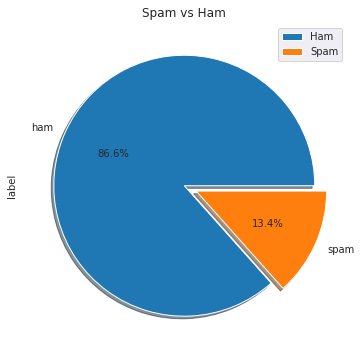

In [11]:
messages["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

**A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.**

Text(0, 0.5, 'Frequency')

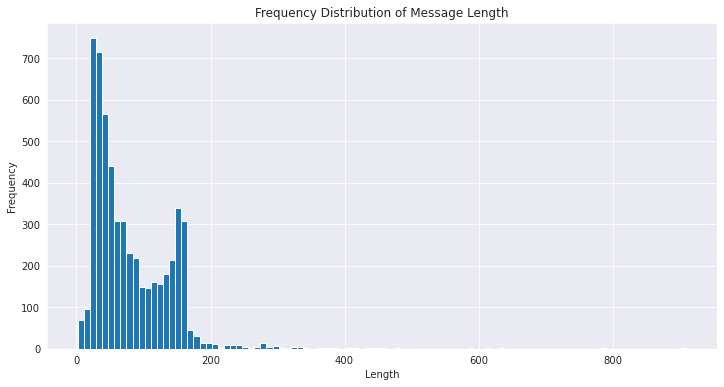

In [12]:
plt.figure(figsize=(12,6))
messages['length'].plot(bins=100, kind='hist') # with 100 length bins (100 length intervals) 
plt.title("Frequency Distribution of Message Length")
plt.xlabel("Length")
plt.ylabel("Frequency")

Most of the message lenght is less than 200. Note that x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [13]:
messages['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [14]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5f1a8ed90>,
      dtype=object)

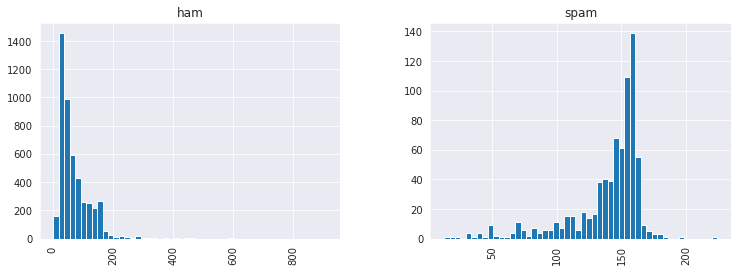

In [15]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Looks like spam messages are usually longer. Maybe message length can become a feature to predict whether the message is spam/ ham ?

Now let's begin to process the data so we can eventually use it with SciKit Learn!

# Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a **corpus** to a vector format. The simplest is the the [bag-of-words](https://github.com/dktalaicha/Natural-Language-Processing/blob/master/Natural-Language-Processing-Basics.ipynb) approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words i.e. **stopwords**, ('the', 'a', etc..). To do this we will take advantage of the NLTK library.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [16]:
def text_preprocess(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    # Now just remove any stopwords and non alphabets
    nostop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    return nostop

Now let's "tokenize" these spam or ham messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

<div class="alert alert-block alert-warning">
<b>Note:</b> 
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)
</div>

## Lets study individual spam/ham messages

In [17]:
spam_messages = messages[messages["label"] == "spam"]["message"]
ham_messages = messages[messages["label"] == "ham"]["message"]
print("No of spam messages : ",len(spam_messages))
print("No of ham messages : ",len(ham_messages))

No of spam messages :  747
No of ham messages :  4825


## Wordcloud for Spam Messages

In [18]:
# This may take a while....
spam_words = text_preprocess(spam_messages)

In [19]:
# lets print some spam words
spam_words[:10]

['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may']

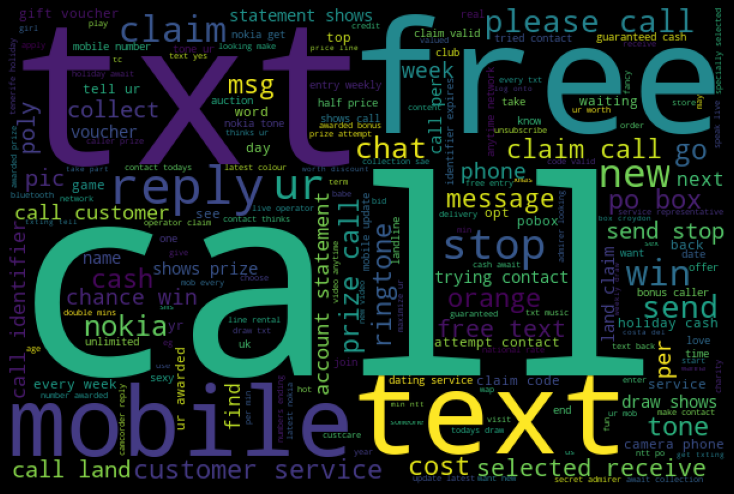

In [20]:
spam_wordcloud = WordCloud(width=600, height=400).generate(' '.join(spam_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Wordcloud for spam messages shows that words like call, txt, win, free, reply, mobile, text etc. are widely used, let's check them statistically.**

In [21]:
print("Top 10 Spam words are :\n")
print(pd.Series(spam_words).value_counts().head(10))

Top 10 Spam words are :

call      331
free      146
txt       136
ur        129
mobile    108
text      107
claim     105
reply      98
u          98
stop       78
dtype: int64


## Wordcloud for Ham Messages

In [22]:
# This may take a while...
ham_words = text_preprocess(ham_messages)

In [23]:
# lets pring some ham words
ham_words[:10]

['go',
 'jurong',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'cine']

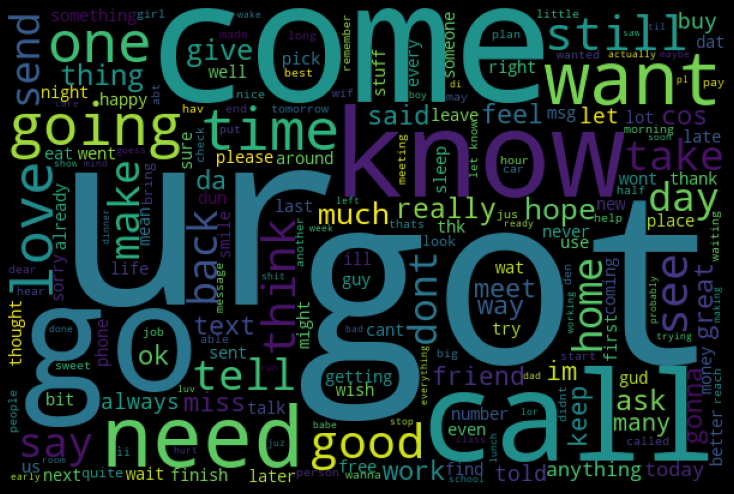

In [24]:
ham_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ham_words))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Wordcloud for ham messages shows that words like got, come, go, ur, know, call etc. are widely used, let's check them statistically.**

In [25]:
print("Top 10 Ham words are :\n")
print(pd.Series(ham_words).value_counts().head(10))

Top 10 Ham words are :

u        820
get      287
ur       235
go       231
got      216
like     215
know     202
come     201
call     200
going    151
dtype: int64


# Data Transformation

Lets clean our data by removing punctuations/ stopwords.

In [26]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [27]:
# This might take a while....

# Lets remove punctuations/ stopwords from all SMS 
messages["message"] = messages["message"].apply(text_preprocess)

In [28]:
# Conver the SMS into string from list
messages["message"] = messages["message"].agg(lambda x: ' '.join(map(str, x)))

In [29]:
messages.head()

,label,message,length
0,ham,go jurong point crazy available bugis n great ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry wkly comp win fa cup final tkts may...,155
3,ham,u dun say early hor u c already say,49
4,ham,nah dont think goes usf lives around though,61


In [30]:
messages["message"][7]

'per request melle melle oru minnaminunginte nurungu vettam set callertune callers press copy friends callertune'

# Continuing Normalization

There are a lot of ways to continue normalizing the text. Such as **Stemming** or distinguishing by **part of speech**.

NLTK has lots of built-in tools. However sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so we are not going to use them here. For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of these messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the **bag-of-words** model:

1. Count how many times does a word occur in each message (Known as term frequency or **TF**)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency or **IDF**)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

Countvectorizer counts the number of times a token shows up in the messages and uses this value as its weight.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a Sparse Matrix.

## Creating the Bag of Words

In [31]:
# Creating the Bag of Words

# Note the here we are passing already process messages (after removing punctuations and stopwords)

vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(messages['message'])

print("20 Bag of Words (BOW) Features: \n")
print(vectorizer.get_feature_names()[20:40])

print("\nTotal number of vocab words : ",len(vectorizer.vocabulary_))

20 Bag of Words (BOW) Features: 

['absence', 'absolutely', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abusers', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation']

Total number of vocab words :  8084


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [32]:
message4 = messages['message'][3]
print(message4)

u dun say early hor u c already say


Now let's see its vector representation:

In [33]:
# fit_transform : Learn the vocabulary dictionary and return term-document matrix.
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 207)	1
  (0, 1981)	1
  (0, 2000)	1
  (0, 3141)	1
  (0, 5945)	2
(1, 8084)


This means that there are seven unique words in message number 4 (after removing common stop words). Let's go ahead and check and confirm which ones appear twice:

In [34]:
print(bow_transformer.get_feature_names()[5945])

say


#### Now we can use **.transform** on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [35]:
messages_bow = bow_transformer.transform(messages['message'])

In [36]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 8084)
Amount of Non-Zero occurences:  44211


After the counting, the term weighting and normalization can be done with TF-IDF.

### TF-IDF

TF-IDF stands for **term frequency-inverse document frequency**, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.


**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

$$ TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}. $$
   

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

$$ IDF(t) = \log_e\Bigg( \frac{\text{Total number of documents}}{\text{Number of documents with term t in it}} \Bigg). $$

Let's do this in SciKit Learn.

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)

Let's try classifying our single random message and checking how we do:

In [38]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 5945)	0.6206136295983186
  (0, 3141)	0.5139528069861297
  (0, 2000)	0.37127907512470754
  (0, 1981)	0.3420160440299522
  (0, 207)	0.3096257562744466


In [39]:
print(bow_transformer.get_feature_names()[5945])
print(bow_transformer.get_feature_names()[3141])

say
hor


We'll go ahead and check what is the IDF (inverse document frequency) of the `"say"`?

In [40]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['say']])

5.14835197309133


### To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [41]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 8084)


In [42]:
messages["message"][:10]

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts may...
3                  u dun say early hor u c already say
4          nah dont think goes usf lives around though
5    freemsg hey darling weeks word back id like fu...
6       even brother like speak treat like aids patent
7    per request melle melle oru minnaminunginte nu...
8    winner valued network customer selected receiv...
9    mobile months u r entitled update latest colou...
Name: message, dtype: object

### Lets convert our clean text into a representation that a machine learning model can understand. I'll use the Tfifd for this.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(encoding = "latin-1", strip_accents = "unicode", stop_words = "english")
features = vec.fit_transform(messages["message"])
print(features.shape)

print(len(vec.vocabulary_))

(5572, 7927)
7927


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit Learn's documentation on dealing with text data as well as the expansive collection of available papers and books on the general topic of NLP.

# Model Evaluation

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with:

#### Encoding class labels in Target Variable (Not Mandatory)

Encoding the Target variable (here label as spam or ham) into numeric form is ideal before data is fed to Machine Learning algorithms. I am just escaping this now as Naive Bayes can work with categorial target variable. 

In [44]:
# FactorResult=pd.factorize(messages['label'])
# messages['label'] = FactorResult[0]
# messages.head()

## Train Test Split

In [45]:
msg_train, msg_test, label_train, label_test = \
train_test_split(messages_tfidf, messages['label'], test_size=0.2)

In [46]:
print("train dataset features size : ",msg_train.shape)
print("train dataset label size", label_train.shape)

print("\n")

print("test dataset features size", msg_test.shape)
print("test dataset lable size", label_test.shape)

train dataset features size :  (4457, 8084)
train dataset label size (4457,)


test dataset features size (1115, 8084)
test dataset lable size (1115,)


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Building Naive Bayes classifier Model

Let's create a Naive Bayes classifier Model using Scikit-learn.

In [47]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
spam_detect_model = clf.fit(msg_train, label_train)

In [48]:
predict_train = spam_detect_model.predict(msg_train)

In [49]:
print("Classification Report \n",metrics.classification_report(label_train, predict_train))
print("\n")
print("Confusion Matrix \n",metrics.confusion_matrix(label_train, predict_train))
print("\n")
print("Accuracy of Train dataset : {0:0.3f}".format(metrics.accuracy_score(label_train, predict_train)))

Classification Report 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      3867
        spam       1.00      0.79      0.88       590

    accuracy                           0.97      4457
   macro avg       0.98      0.90      0.93      4457
weighted avg       0.97      0.97      0.97      4457



Confusion Matrix 
 [[3867    0]
 [ 122  468]]


Accuracy of Train dataset : 0.973


Let's try classifying our single random message and checking how we do:

In [50]:
print('predicted:', spam_detect_model.predict(tfidf4)[0])
print('expected:', messages['label'][3])

predicted: ham
expected: ham


Fantastic! We've developed a model that can attempt to predict spam vs ham classification!

## Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's begin by getting all the predictions:

In [51]:
label_predictions = spam_detect_model.predict(msg_test)
print(label_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


We can use SciKit Learn's built-in classification report, which returns precision, recall f1-score, and a column for support (meaning how many cases supported that classification).

In [52]:
print(metrics.classification_report(label_test, label_predictions))
print(metrics.confusion_matrix(label_test, label_predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       958
        spam       1.00      0.73      0.84       157

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

[[958   0]
 [ 43 114]]


There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

In [53]:
# Printing the Overall Accuracy of the model
print("Accuracy of the model : {0:0.3f}".format(metrics.accuracy_score(label_test, label_predictions)))

Accuracy of the model : 0.961


### I welcome comments, suggestions, corrections and of course votes also.